### Task 158: V2 liquidity fix
* k: constant product (ie, x*y = k)
* R0: Reserve0
* R1: Reserve1
* Ai: Amount of input token 
* Ao: Amount of output token 

#### Mathematical Mapping Legend
* reserveIn (R1) -> x
* reserveOut (R0) -> y
* amountIn (Ai) -> $\Delta$x
* amountOut (Ao) -> $\Delta$y
* 1 - swap fee -> r = (1 - 0.003) or (997/1000)

In [1]:
from IPython.display import Image
import os
cwd =  os.getcwd().replace("notebooks/research/ian","")
os.chdir(cwd)

### References
* [Reference Example](https://betterprogramming.pub/uniswap-v2-in-depth-98075c826254)
* [Function swap in v2 core](https://github.com/Uniswap/v2-core/blob/master/contracts/UniswapV2Pair.sol#L159)
* [Functions getAmountsOut and getAmountsIn in v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol)

#### Mathematical Expose
Let’s recall the constant product formula:<br>
> x*y = k 

Where x and y are pair reserves (reserve0 and reserve1). When doing a swap, x and y are changed but k remains the same (or, actually, it grows slowly thanks to swap fees). We can write this as a formula:
> (x+rΔx)(y−Δy)=xy

Where r is 1 - swap fee (1 - 0.3% = 0.997), \Delta xΔx is the amount we give in exchange for \Delta yΔy, the amount we get. <br>

This is a very nice and concise formula that shows that the product of reserves after a swap must be equal to the product of reserves before the swap, which is the definition of the constant product formula. And we can use this formula to calculate the amount we get during a swap. After doing some basic algebraic operations, we get this:
> $\Delta$y = $\frac{yr\Delta x}{x+r \Delta x}$

As you can see, this is a relation of two reserves (y/x) that takes into consideration the input amount (r$\Delta$x), including the fee.

Let’s program this out:

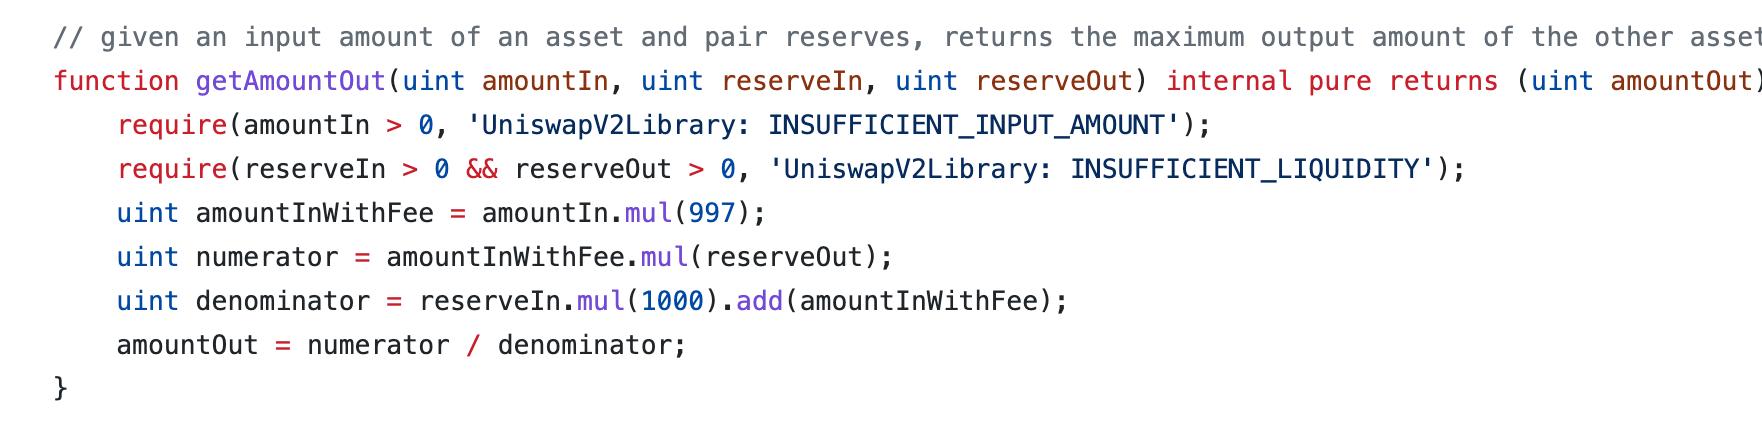

In [2]:
Image("images/jupyter/uniswap_v2/getAmountOut.png",  width = 900, height = 200)

[See function getAmountsOut on line 42 in uniswap v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol#L42)

Above, we see amountIn is $\Delta$x, reserveIn is x, reserveOut is y. Because of Solidity not supporting float point division, we need to multiply numerator and denominator by 1000 and then subtract 3 from the multiplier applied to amountIn–this will apply the 0.3% fee to amountIn:

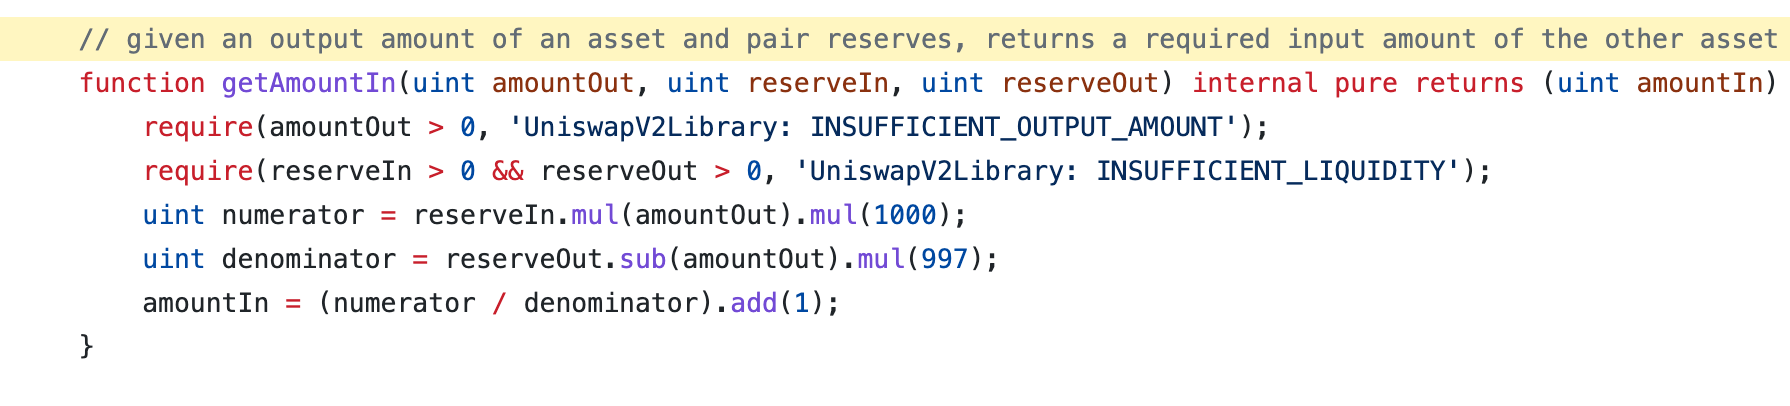

In [3]:
Image("images/jupyter/uniswap_v2/getAmountIn.png",  width = 900, height = 200)

[See function getAmountsIn on line 52 in uniswap v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol#L52)

Now we can proceed with swapping.

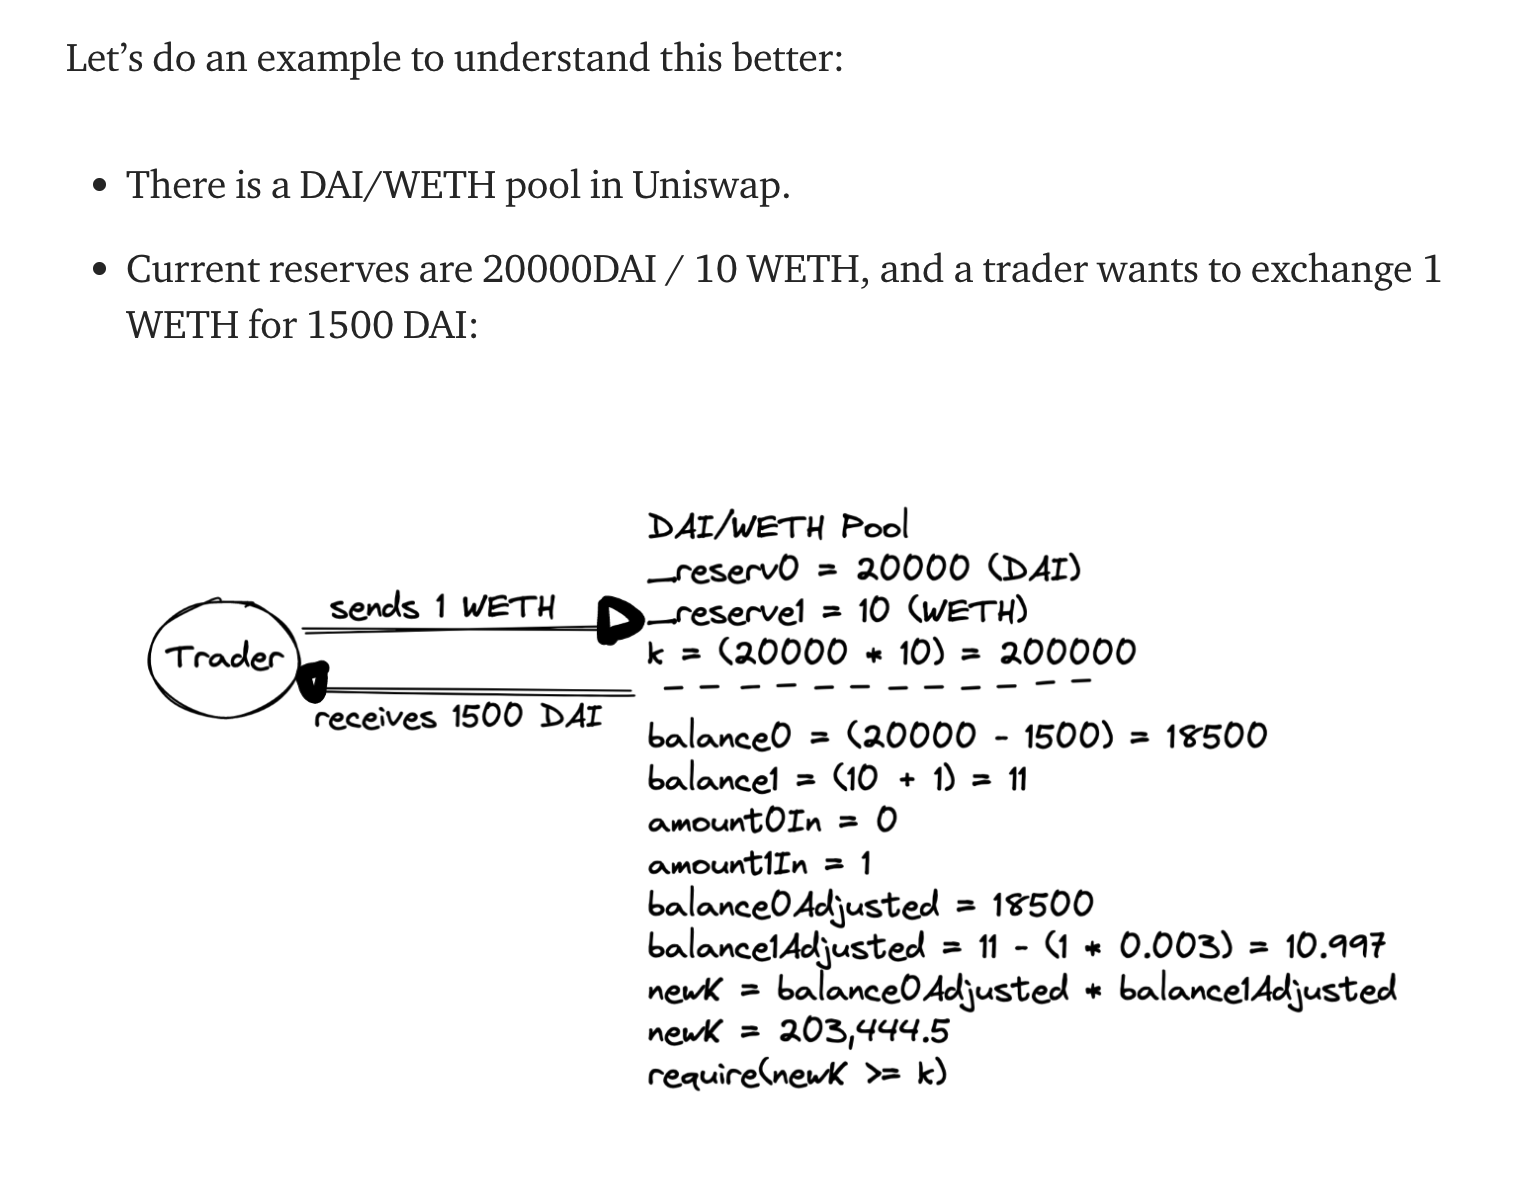

In [4]:
Image("images/jupyter/uniswap_v2/example.png", width = 600, height = 600)

### Initial Problem setup

We will send 1 WETH and get 1500 DAI; the original reserves are 20000 DAI and 10 WETH

In [5]:
Ai = 1; Ao = 1500

print('We swap {} WETH to get {} DIA'.format(Ai,Ao))

We swap 1 WETH to get 1500 DIA


In [6]:
R0 = 20000; R1 = 10

print('Original reserve of {} DIA and {} WETH'.format(R0, R1))

Original reserve of 20000 DIA and 10 WETH


### Run simplified swap

First, calculate balances

In [7]:
k = R0*R1
bal0 = R0 - Ao
bal1 = R1 + Ai

Then calculate adjusted balances

In [8]:
A0i = 0 
A1i = 1
bal0Adj = bal0*1000-A0i*3

print('Adjusted R0 after swap: {}'.format(bal0Adj/1000))

Adjusted R0 after swap: 18500.0


In [9]:
bal1Adj = bal1*1000-A1i*3

print('Adjusted R1 after swap: {}'.format(bal1Adj/1000))

Adjusted R1 after swap: 10.997


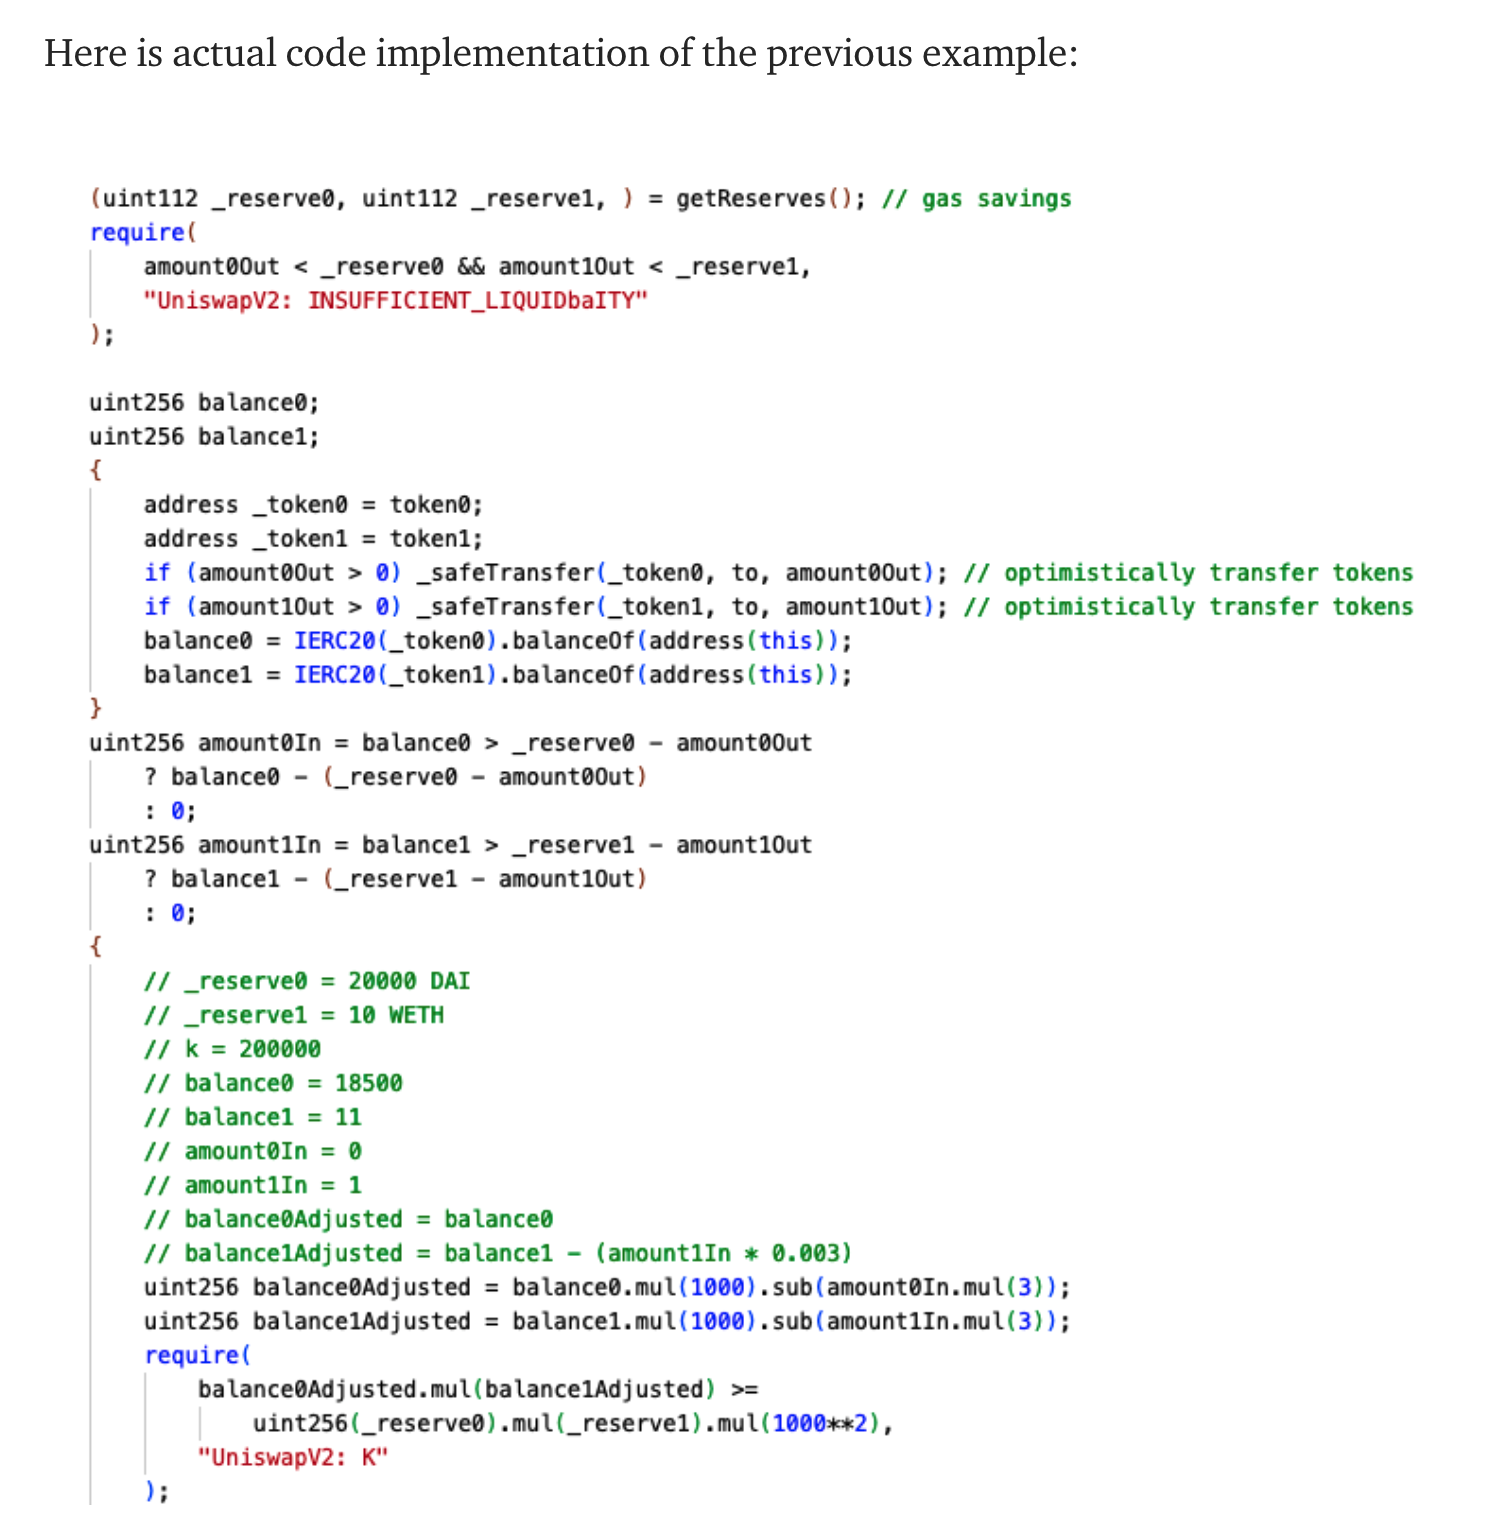

In [10]:
Image("images/jupyter/uniswap_v2/example_code.png", width = 600, height = 600)

[See function swap on line 159 in uniswap v2 core](https://github.com/Uniswap/v2-core/blob/master/contracts/UniswapV2Pair.sol#L159)

### Part 1: Perform complete swap

The above swap is a simplifcation, next we must factor getting the maximum amount of tokens that you can get for a given input. First we determing amount out accordance to [function getAmountOut on line 42 in uniswap v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol#L42) (or see above for code snippet) 

In [11]:
def getAmountOut(Ai,Ro,Ri):
    return (Ro*997*Ai)/(Ri*1000 + Ai*997)

Then we get amount in accordance to [function getAmountIn on line 52 in uniswap v2 periphery](https://github.com/Uniswap/v2-periphery/blob/master/contracts/libraries/UniswapV2Library.sol#L52) (or see above for code snippet)

In [12]:
def getAmountIn(Ao,Ro,Ri):
    return (Ri*1000*Ao)/(997*(Ro-Ao))

Next, we calculated the amount out in accordance to our input of 1 WETH

In [13]:
Ao = getAmountOut(Ai,R0,R1)

print('To get {} WETH, we need {} DIA'.format(Ai,Ao))

To get 1 WETH, we need 1813.2217877602982 DIA


Then we confirm the amount in accordance to our above calculated output **(should be 1 WETH)**

In [14]:
Ai = getAmountIn(Ao,R0,R1)

print('Confirming that {} WETH is required as input'.format(Ai))

Confirming that 1.0000000000000002 WETH is required as input


Finally, perform swap in accordance to [function swap on line 159 in uniswap v2 core](https://github.com/Uniswap/v2-core/blob/master/contracts/UniswapV2Pair.sol#L159) to updated the new balances

In [15]:
def swap(Ai,Ao,R0,R1):
    
    k = R0*R1
    bal0 = R0 - Ao
    bal1 = R1 + Ai 
    
    A0i = 0 
    A1i = Ai
    bal0Adj = bal0*1000-A0i*3
    bal1Adj = bal1*1000-A1i*3  
    
    newK = bal0Adj*bal1Adj
    
    return bal0Adj/1000, bal1Adj/1000

In [16]:
newR0, newR1 = swap(Ai,Ao,R0,R1)

print('After swap we now have {} DIA and {} WETH'.format(newR0, newR1))

After swap we now have 18186.7782122397 DIA and 10.997 WETH


### Part 2: Extract LP from one of the token reserves

Start with extraction of r$\Delta$y from one of the reserves, which results in extraction of $\Delta$k liquidity from pool
> (x)(y - r$\Delta$y) = k - $\Delta$k

Do the algebra, and we have amount LP out:
> $\Delta$ k = xr$\Delta$y

Likewise, we have amount desired token reserve that is required:
> $\Delta$ y = $\frac{\Delta k}{rx}$

In [17]:
def getAmountLPOut(Ai,reserve):
    return reserve*997*Ai/1000

def getAmountIn4LP(Ro,reserve):
    return (1000*Ro)/(997*reserve) 

In [18]:
Ai  = 1

Ro = getAmountLPOut(Ai,R0)

print('To remove {} WETH, we need to extract {} LP'.format(Ai,Ro))

To remove 1 WETH, we need to extract 19940.0 LP


In [19]:
Ai = getAmountIn4LP(Ro,R0)

print('Confirming that {} WETH is required as input'.format(Ai))

Confirming that 1.0 WETH is required as input


### Check

In [20]:
raw = R0*R1 - Ro
actual = R0*(R1-Ai*997/1000)
check = 'pass' if raw == actual else 'fail'

print('Check: {}'.format(check))

Check: pass


Finally, using swap function above as our template, we update the reserves

In [21]:
def extractLP(Ai,Ao,R0,R1):
    
    k = R0*R1
    bal0 = R0 - Ao
    bal1 = R1 - Ai 
    
    A0i = 0 
    A1i = Ai
    bal0Adj = bal0*1000+A0i*3
    bal1Adj = bal1*1000+A1i*3  
    
    newK = bal0Adj*bal1Adj
    
    return newK/1000000, bal0Adj/1000, bal1Adj/1000

In [22]:
newk, newR0, newR1 = extractLP(Ai,0,R0,R1)

print('{} LP remains after extracting {} WETH'.format(newk,Ai))

180060.0 LP remains after extracting 1.0 WETH
